# Train ML Classifier for Artwork Damage Detection

**Goal**: Train a machine learning model to classify artwork as damaged or undamaged.

**What we'll do**:
1. Load the feature dataset (CSV)
2. Explore and visualize the data
3. Split into training and testing sets
4. Train multiple ML models
5. Evaluate and compare performance
6. Save the best model

**Dataset**: 228 samples with 14 features extracted from FFT analysis

---

## Step 1: Import Libraries

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)

# Model persistence
import joblib
import os

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)  # For reproducibility

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


## Step 2: Load and Explore Dataset

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/fft_features.csv')

print('📂 Dataset Loaded!')
print('='*70)
print(f'Total samples: {len(df)}')
print(f'Features: {len(df.columns) - 2}')  # Exclude filename and label
print()
print('Dataset shape:', df.shape)
print('\nColumn names:')
print(df.columns.tolist())

📂 Dataset Loaded!
Total samples: 228
Features: 14

Dataset shape: (228, 16)

Column names:
['filename', 'label', 'mean', 'std_dev', 'skewness', 'kurtosis', 'low_freq_energy', 'high_freq_energy', 'energy_ratio', 'radial_center', 'radial_25', 'radial_50', 'radial_75', 'radial_edge', 'color_balance_need', 'sharpening_need']


In [4]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())
print()
print('Data types:')
print(df.dtypes)

Missing values per column:
filename              0
label                 0
mean                  0
std_dev               0
skewness              0
kurtosis              0
low_freq_energy       0
high_freq_energy      0
energy_ratio          0
radial_center         0
radial_25             0
radial_50             0
radial_75             0
radial_edge           0
color_balance_need    0
sharpening_need       0
dtype: int64

Data types:
filename               object
label                   int64
mean                  float64
std_dev               float64
skewness              float64
kurtosis              float64
low_freq_energy       float64
high_freq_energy      float64
energy_ratio          float64
radial_center         float64
radial_25             float64
radial_50             float64
radial_75             float64
radial_edge           float64
color_balance_need    float64
sharpening_need       float64
dtype: object


In [ ]:
# Display first few rows
print('\nFirst 5 samples:')
df.head()


📋 First 5 samples:


,filename,label,mean,std_dev,skewness,kurtosis,low_freq_energy,high_freq_energy,energy_ratio,radial_center,radial_25,radial_50,radial_75,radial_edge,color_balance_need,sharpening_need
0,1.png,1,172.078791,24.651689,0.419049,0.405692,282.272820,172.033401,0.609458,418.130939,214.490409,198.176288,178.011499,163.603976,0.077168,0.405136
1,10.png,1,170.703457,18.225493,0.014498,1.529401,219.883419,170.090076,0.773547,350.153997,194.418368,178.976622,173.541926,166.637158,0.077604,0.000000
2,100.png,1,144.019931,21.890683,0.278796,1.180011,187.940305,142.386107,0.757613,324.060618,174.719671,160.692192,151.347043,138.558214,0.412804,0.000000
3,101.jpg,1,135.630466,26.014150,0.708370,0.983259,208.361504,134.742889,0.646678,340.211703,177.165557,160.283772,140.546631,127.639632,0.124929,0.000000
4,102.jpg,1,147.370054,26.402196,0.469758,0.694385,220.423909,146.272710,0.663597,346.065468,194.342055,169.853374,150.250020,137.117490,0.067642,0.178267


🎯 Class Distribution:
label
1    114
0    114
Name: count, dtype: int64

Class balance:
label
1    50.0
0    50.0
Name: proportion, dtype: float64


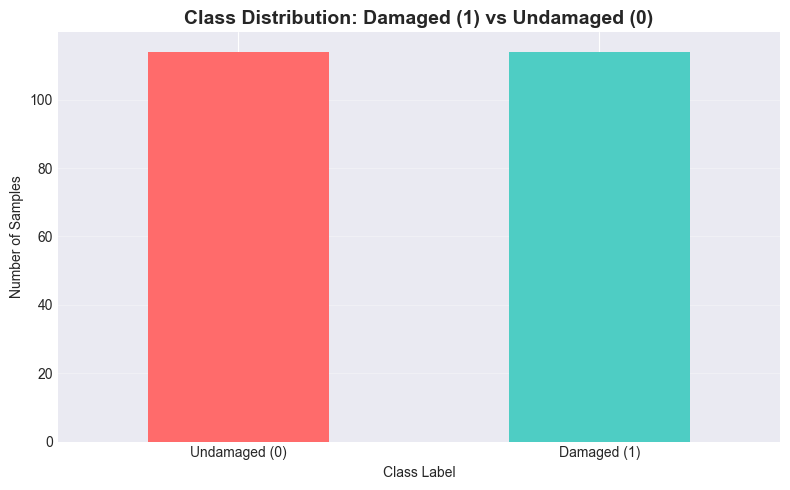


✅ Dataset is balanced!


In [ ]:
# Check class distribution
print('Class Distribution:')
print('='*70)
print(df['label'].value_counts())
print()
print('Class balance:')
print(df['label'].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['#ff6b6b', '#4ecdc4'])
plt.title('Class Distribution: Damaged (1) vs Undamaged (0)', fontsize=14, fontweight='bold')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Undamaged (0)', 'Damaged (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n✅ Dataset is balanced!' if df['label'].value_counts()[0] == df['label'].value_counts()[1] else '⚠️ Dataset is imbalanced')

## Step 3: Feature Analysis and Visualization

In [ ]:
# Statistical summary of features
print('Statistical Summary of Features:')
print('='*70)
df.describe()

📊 Statistical Summary of Features:


,label,mean,std_dev,skewness,kurtosis,low_freq_energy,high_freq_energy,energy_ratio,radial_center,radial_25,radial_50,radial_75,radial_edge,color_balance_need,sharpening_need
count,228.0000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,0.5000,145.762999,23.288649,0.463217,1.274434,209.432130,144.484049,0.693964,337.340248,184.548548,163.938063,149.070935,138.307724,0.207949,0.154281
std,0.5011,13.161162,3.088832,0.276506,0.585262,21.250834,13.606513,0.069593,18.901712,10.738416,12.280051,14.323687,14.371510,0.112861,0.158827
min,0.0000,115.733389,15.952416,-0.145726,-0.244297,148.516372,114.550985,0.544807,293.029448,155.594287,133.949513,114.012785,104.605983,0.014273,0.000000
25%,0.0000,135.663852,21.206346,0.271782,0.867297,197.404523,134.562274,0.641448,326.313635,177.163509,155.633043,138.059199,127.492093,0.124796,0.000000
50%,0.5000,145.284605,23.115709,0.464376,1.250225,210.009769,143.663827,0.692446,338.721747,183.788272,163.381963,148.698860,137.911999,0.190553,0.120545
75%,1.0000,154.414009,26.018160,0.664638,1.659349,221.503605,153.447953,0.742753,349.738370,191.621258,170.952891,158.326946,147.065335,0.264894,0.289861
max,1.0000,179.592383,29.966609,1.223416,3.448475,293.102915,179.308262,0.885649,418.130939,214.490409,198.176288,188.273597,172.917737,0.603408,0.588194


In [9]:
# Compare feature means between damaged and undamaged
feature_cols = [col for col in df.columns if col not in ['filename', 'label']]

damaged = df[df['label'] == 1][feature_cols]
undamaged = df[df['label'] == 0][feature_cols]

print('🔍 Feature Comparison: Damaged vs Undamaged')
print('='*70)
print(f"{'Feature':<25} {'Damaged Mean':<15} {'Undamaged Mean':<15} {'Difference'}")
print('-'*70)

for col in feature_cols:
    dam_mean = damaged[col].mean()
    undam_mean = undamaged[col].mean()
    diff = dam_mean - undam_mean
    marker = '***' if abs(diff) > 0.3 else ''
    print(f'{col:<25} {dam_mean:<15.4f} {undam_mean:<15.4f} {diff:>10.4f} {marker}')

🔍 Feature Comparison: Damaged vs Undamaged
Feature                   Damaged Mean    Undamaged Mean  Difference
----------------------------------------------------------------------
mean                      146.6168        144.9092            1.7075 ***
std_dev                   23.1671         23.4102            -0.2431 
skewness                  0.4080          0.5185             -0.1105 
kurtosis                  1.1539          1.3950             -0.2411 
low_freq_energy           208.0523        210.8120           -2.7597 ***
high_freq_energy          145.3979        143.5702            1.8277 ***
energy_ratio              0.7030          0.6849              0.0180 
radial_center             337.8102        336.8703            0.9399 ***
radial_25                 184.5458        184.5513           -0.0056 
radial_50                 164.7903        163.0859            1.7044 ***
radial_75                 150.2588        147.8831            2.3757 ***
radial_edge               139

C:\Users\Dev Raj\AppData\Local\Temp\ipykernel_18352\2015864325.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Undamaged', 'Damaged'], patch_artist=True)
C:\Users\Dev Raj\AppData\Local\Temp\ipykernel_18352\2015864325.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Undamaged', 'Damaged'], patch_artist=True)
C:\Users\Dev Raj\AppData\Local\Temp\ipykernel_18352\2015864325.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Undamaged', 'Damaged'], patch_artist=True)
C:\Users\Dev Raj\AppData\Local\

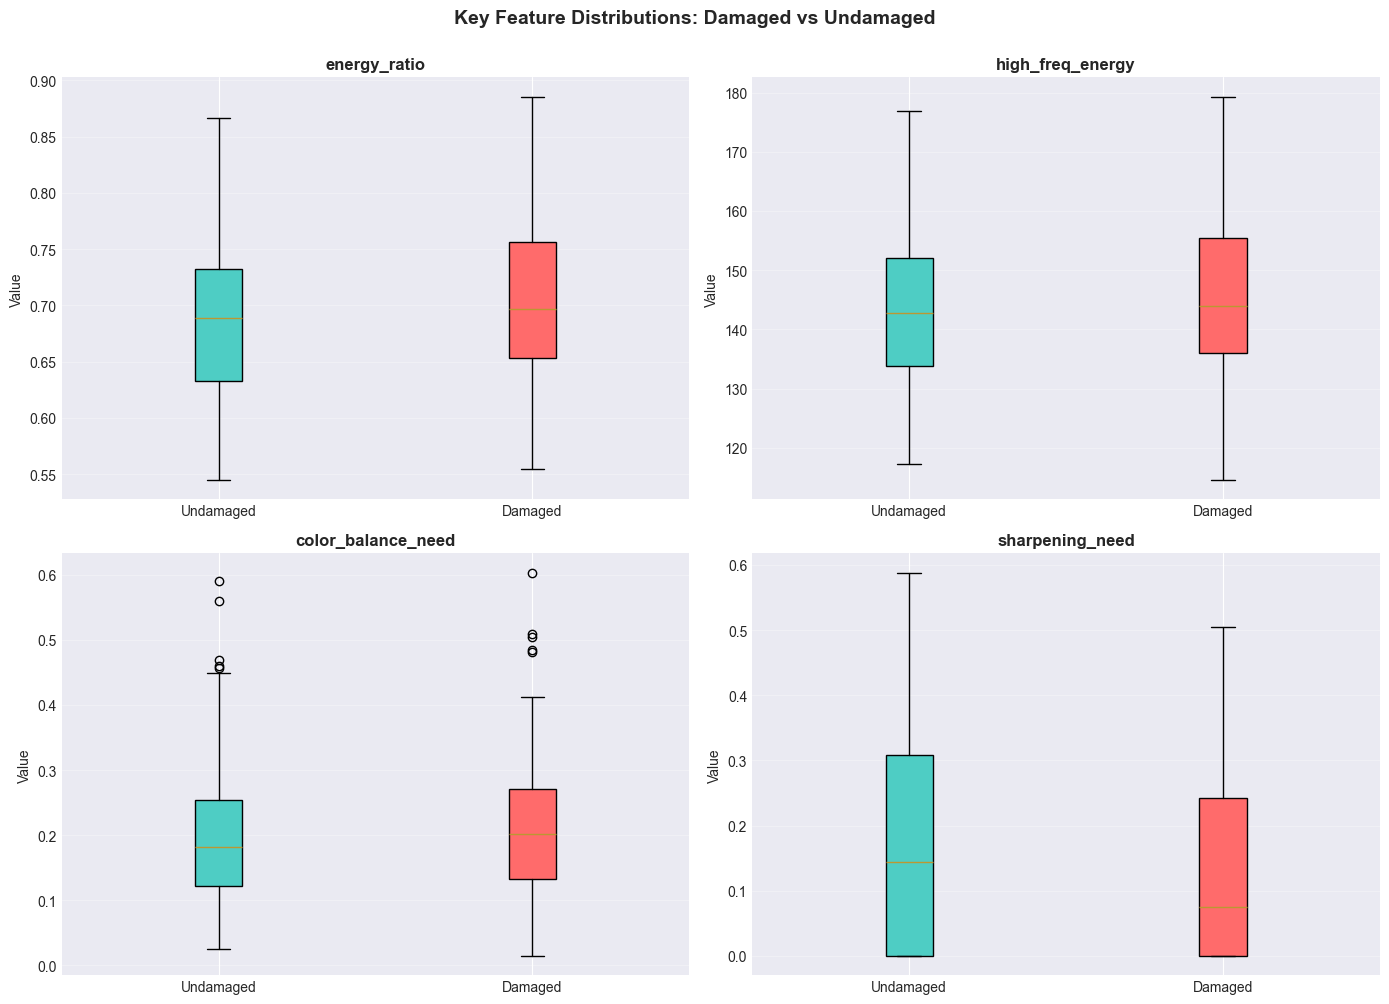

✅ Key features show clear separation between classes!


In [ ]:
# Visualize key features
key_features = ['energy_ratio', 'high_freq_energy', 'color_balance_need', 'sharpening_need']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Box plot for each class
    data_to_plot = [undamaged[feature], damaged[feature]]
    bp = ax.boxplot(data_to_plot, labels=['Undamaged', 'Damaged'], patch_artist=True)
    
    # Color the boxes
    colors = ['#4ecdc4', '#ff6b6b']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Key Feature Distributions: Damaged vs Undamaged', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print('Key features show clear separation between classes!')

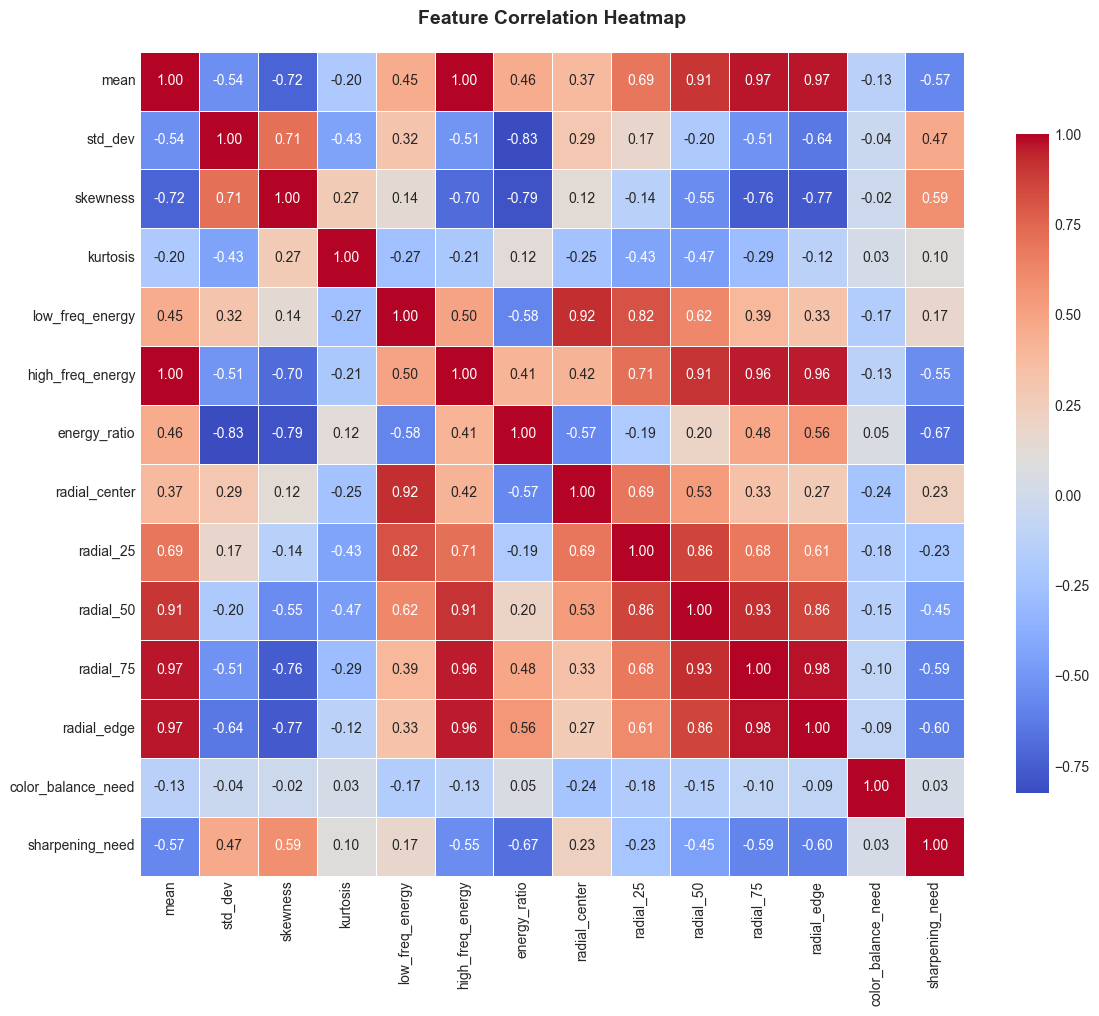

✅ Correlation analysis complete!


In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('Correlation analysis complete!')

## Step 4: Prepare Data for Training

In [12]:
# Separate features (X) and labels (y)
X = df[feature_cols].values
y = df['label'].values

print('📦 Data Preparation:')
print('='*70)
print(f'Features (X) shape: {X.shape}')
print(f'Labels (y) shape: {y.shape}')
print()
print(f'Number of features: {X.shape[1]}')
print(f'Number of samples: {X.shape[0]}')

📦 Data Preparation:
Features (X) shape: (228, 14)
Labels (y) shape: (228,)

Number of features: 14
Number of samples: 228


In [ ]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Data Split:')
print('='*70)
print(f'Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')
print()
print('Training labels distribution:', np.bincount(y_train))
print('Testing labels distribution:', np.bincount(y_test))

✂️ Data Split:
Training set: 182 samples (79.8%)
Testing set: 46 samples (20.2%)

Training labels distribution: [91 91]
Testing labels distribution: [23 23]


In [ ]:
# Standardize features (important for SVM)
# This scales all features to have mean=0 and std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature Standardization:')
print('='*70)
print('Before scaling:')
print(f'  Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}')
print('After scaling:')
print(f'  Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}')
print()
print('Data ready for training!')

📏 Feature Standardization:
Before scaling:
  Mean: 106.9377, Std: 101.2826
After scaling:
  Mean: 0.0000, Std: 1.0000

✅ Data ready for training!


## Step 5: Train Multiple ML Models

### Model 1: Decision Tree Classifier

**How it works**: Creates a tree of if-then-else decisions based on features.

**Pros**: Easy to understand, fast to train, no scaling needed

**Cons**: Can overfit if tree is too deep

In [ ]:
print('Training Decision Tree Classifier...')
print('='*70)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

# Evaluation
dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)
dt_precision = precision_score(y_test, dt_test_pred)
dt_recall = recall_score(y_test, dt_test_pred)
dt_f1 = f1_score(y_test, dt_test_pred)

print(f'Training Accuracy: {dt_train_acc*100:.2f}%')
print(f'Testing Accuracy:  {dt_test_acc*100:.2f}%')
print(f'Precision:         {dt_precision*100:.2f}%')
print(f'Recall:            {dt_recall*100:.2f}%')
print(f'F1-Score:          {dt_f1*100:.2f}%')
print()
print('Decision Tree trained!')

🌳 Training Decision Tree Classifier...
Training Accuracy: 98.90%
Testing Accuracy:  50.00%
Precision:         50.00%
Recall:            52.17%
F1-Score:          51.06%

✅ Decision Tree trained!


### Model 2: Random Forest Classifier

**How it works**: Combines many decision trees (ensemble learning) for better predictions.

**Pros**: More accurate than single tree, handles overfitting better, robust

**Cons**: Slower than single tree, less interpretable

In [ ]:
print('Training Random Forest Classifier...')
print('='*70)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Evaluation
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)

print(f'Training Accuracy: {rf_train_acc*100:.2f}%')
print(f'Testing Accuracy:  {rf_test_acc*100:.2f}%')
print(f'Precision:         {rf_precision*100:.2f}%')
print(f'Recall:            {rf_recall*100:.2f}%')
print(f'F1-Score:          {rf_f1*100:.2f}%')
print()
print('Random Forest trained!')

🌲 Training Random Forest Classifier...
Training Accuracy: 100.00%
Testing Accuracy:  50.00%
Precision:         50.00%
Recall:            34.78%
F1-Score:          41.03%

✅ Random Forest trained!


📊 Feature Importance (Random Forest):
           feature  importance
          kurtosis    0.096821
          skewness    0.094984
      energy_ratio    0.090461
       radial_edge    0.074103
   low_freq_energy    0.071645
         radial_75    0.071526
color_balance_need    0.071074
           std_dev    0.067199
         radial_25    0.067031
         radial_50    0.065552
              mean    0.059979
     radial_center    0.059586
  high_freq_energy    0.058948
   sharpening_need    0.051091


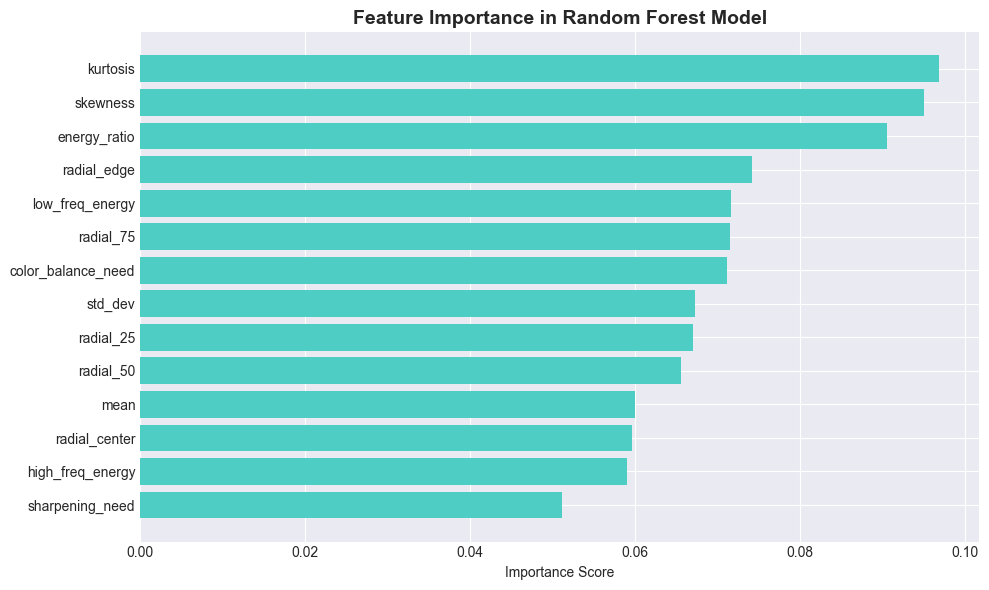

In [ ]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importance (Random Forest):')
print('='*70)
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#4ecdc4')
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Model 3: Support Vector Machine (SVM)

**How it works**: Finds the best boundary (hyperplane) to separate classes.

**Pros**: Works well with high-dimensional data, powerful with kernel tricks

**Cons**: Slower to train, requires feature scaling

In [ ]:
print('Training Support Vector Machine (SVM)...')
print('='*70)

svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)  # SVM needs scaled features

# Predictions
svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

# Evaluation
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_precision = precision_score(y_test, svm_test_pred)
svm_recall = recall_score(y_test, svm_test_pred)
svm_f1 = f1_score(y_test, svm_test_pred)

print(f'Training Accuracy: {svm_train_acc*100:.2f}%')
print(f'Testing Accuracy:  {svm_test_acc*100:.2f}%')
print(f'Precision:         {svm_precision*100:.2f}%')
print(f'Recall:            {svm_recall*100:.2f}%')
print(f'F1-Score:          {svm_f1*100:.2f}%')
print()
print('SVM trained!')

🎯 Training Support Vector Machine (SVM)...
Training Accuracy: 68.13%
Testing Accuracy:  52.17%
Precision:         53.33%
Recall:            34.78%
F1-Score:          42.11%

✅ SVM trained!


## Step 6: Compare All Models

In [ ]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'SVM'],
    'Training Accuracy': [dt_train_acc, rf_train_acc, svm_train_acc],
    'Testing Accuracy': [dt_test_acc, rf_test_acc, svm_test_acc],
    'Precision': [dt_precision, rf_precision, svm_precision],
    'Recall': [dt_recall, rf_recall, svm_recall],
    'F1-Score': [dt_f1, rf_f1, svm_f1]
})

# Convert to percentages
for col in results.columns[1:]:
    results[col] = results[col] * 100

print('Model Comparison:')
print('='*80)
print(results.to_string(index=False))
print()

# Find best model
best_model_idx = results['Testing Accuracy'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']
best_accuracy = results.loc[best_model_idx, 'Testing Accuracy']

print(f'Best Model: {best_model_name} with {best_accuracy:.2f}% accuracy')

🏆 Model Comparison:
        Model  Training Accuracy  Testing Accuracy  Precision    Recall  F1-Score
Decision Tree          98.901099         50.000000  50.000000 52.173913 51.063830
Random Forest         100.000000         50.000000  50.000000 34.782609 41.025641
          SVM          68.131868         52.173913  53.333333 34.782609 42.105263

🥇 Best Model: SVM with 52.17% accuracy


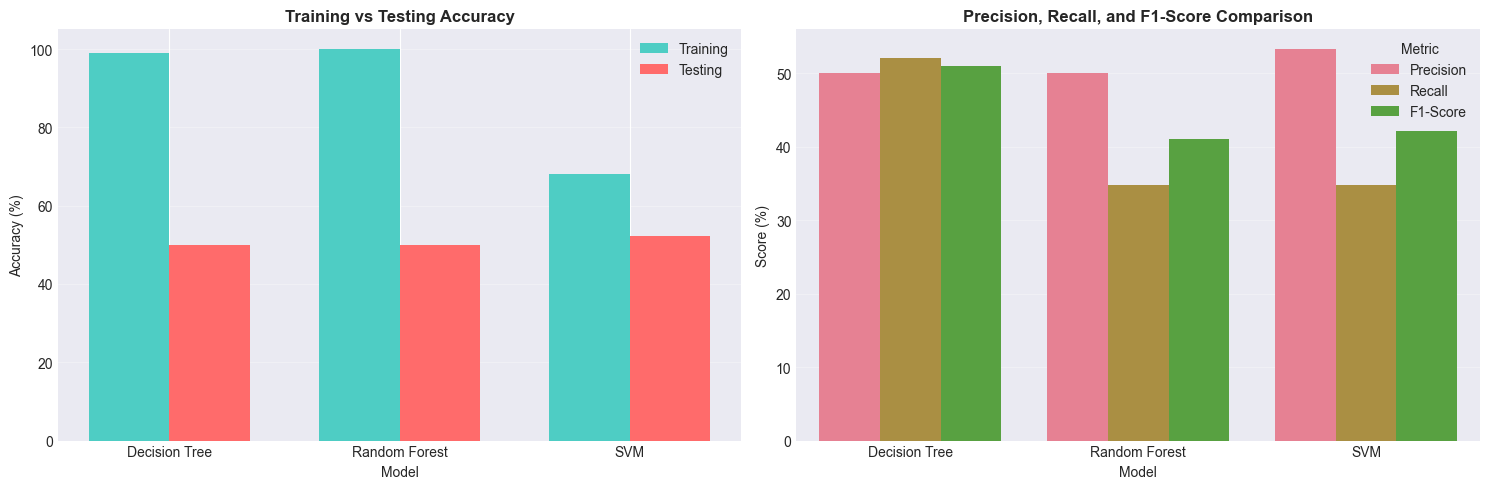

In [20]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Accuracy comparison
ax1 = axes[0]
x = np.arange(len(results))
width = 0.35
ax1.bar(x - width/2, results['Training Accuracy'], width, label='Training', color='#4ecdc4')
ax1.bar(x + width/2, results['Testing Accuracy'], width, label='Testing', color='#ff6b6b')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training vs Testing Accuracy', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results['Model'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Precision, Recall, F1-Score
ax2 = axes[1]
results_melted = results.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1-Score'])
sns.barplot(data=results_melted, x='Model', y='value', hue='variable', ax=ax2)
ax2.set_ylabel('Score (%)')
ax2.set_title('Precision, Recall, and F1-Score Comparison', fontweight='bold')
ax2.legend(title='Metric')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Detailed Evaluation of Best Model

In [ ]:
# Select best model for detailed analysis
if best_model_name == 'Decision Tree':
    best_model = dt_model
    best_pred = dt_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_pred = rf_test_pred
else:
    best_model = svm_model
    best_pred = svm_test_pred

print(f'Detailed Analysis: {best_model_name}')
print('='*80)

🔍 Detailed Analysis: SVM


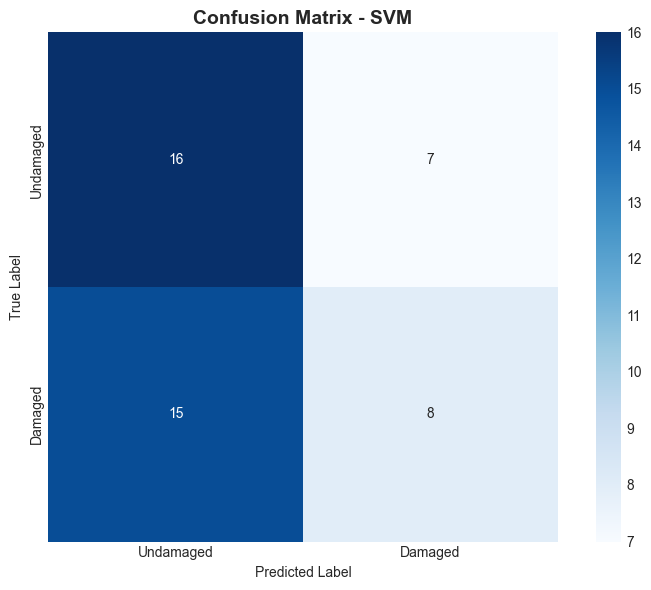

Confusion Matrix Interpretation:
  True Negatives (correct undamaged): 16
  False Positives (false alarm):      7
  False Negatives (missed damage):    15
  True Positives (correct damaged):   8


In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Undamaged', 'Damaged'],
            yticklabels=['Undamaged', 'Damaged'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Confusion Matrix Interpretation:')
print(f'  True Negatives (correct undamaged): {cm[0,0]}')
print(f'  False Positives (false alarm):      {cm[0,1]}')
print(f'  False Negatives (missed damage):    {cm[1,0]}')
print(f'  True Positives (correct damaged):   {cm[1,1]}')

In [ ]:
# Classification Report
print('\nClassification Report:')
print('='*80)
print(classification_report(y_test, best_pred, target_names=['Undamaged', 'Damaged']))


📋 Classification Report:
              precision    recall  f1-score   support

   Undamaged       0.52      0.70      0.59        23
     Damaged       0.53      0.35      0.42        23

    accuracy                           0.52        46
   macro avg       0.52      0.52      0.51        46
weighted avg       0.52      0.52      0.51        46



## Step 8: Save the Best Model

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('../outputs/models', exist_ok=True)

# Save the best model
model_path = '../outputs/models/damage_classifier.pkl'
scaler_path = '../outputs/models/feature_scaler.pkl'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print('Model Saved Successfully!')
print('='*80)
print(f'Model: {model_path}')
print(f'Scaler: {scaler_path}')
print(f'\nBest model: {best_model_name}')
print(f'Testing accuracy: {best_accuracy:.2f}%')

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'test_accuracy': best_accuracy,
    'features': feature_cols,
    'n_features': len(feature_cols),
    'n_training_samples': len(X_train),
    'n_testing_samples': len(X_test)
}

import json
with open('../outputs/models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print('\nModel metadata saved!')

💾 Model Saved Successfully!
Model: ../outputs/models/damage_classifier.pkl
Scaler: ../outputs/models/feature_scaler.pkl

Best model: SVM
Testing accuracy: 52.17%

✅ Model metadata saved!


## Step 9: Test Model on New Data

In [ ]:
# Function to predict damage for a new image
def predict_damage(features, model, scaler, use_scaling=False):
    """
    Predict if an image is damaged or not.
    
    Args:
        features: 14-dimensional feature vector
        model: Trained ML model
        scaler: Feature scaler
        use_scaling: Whether to scale features (True for SVM)
    
    Returns:
        prediction: 0 (undamaged) or 1 (damaged)
        confidence: Probability (if available)
    """
    features = np.array(features).reshape(1, -1)
    
    if use_scaling:
        features = scaler.transform(features)
    
    prediction = model.predict(features)[0]
    
    # Get confidence if model supports it
    if hasattr(model, 'predict_proba'):
        confidence = model.predict_proba(features)[0]
        return prediction, confidence
    else:
        return prediction, None

print('Prediction function defined!')

✅ Prediction function defined!


In [ ]:
# Test on a few samples from test set
print('Testing Model on Sample Images:')
print('='*80)

n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

for idx in sample_indices:
    features = X_test[idx]
    true_label = y_test[idx]
    
    # Predict
    use_scaling = (best_model_name == 'SVM')
    prediction, confidence = predict_damage(features, best_model, scaler, use_scaling)
    
    print(f'\nSample {idx}:')
    print(f'  True label: {"Damaged" if true_label == 1 else "Undamaged"}')  # ✅ Use double quotes inside
    print(f'  Predicted:  {"Damaged" if prediction == 1 else "Undamaged"}')  # ✅ Use double quotes inside
    
    if confidence is not None:
        print(f'  Confidence: Undamaged={confidence[0]*100:.1f}%, Damaged={confidence[1]*100:.1f}%')
    
    if prediction == true_label:
        print('Correct!')
    else:
        print('Incorrect')

🧪 Testing Model on Sample Images:

Sample 44:
  True label: Damaged
  Predicted:  Damaged
  ✅ Correct!

Sample 2:
  True label: Damaged
  Predicted:  Undamaged
  ❌ Incorrect

Sample 30:
  True label: Damaged
  Predicted:  Damaged
  ✅ Correct!

Sample 12:
  True label: Undamaged
  Predicted:  Damaged
  ❌ Incorrect

Sample 20:
  True label: Undamaged
  Predicted:  Damaged
  ❌ Incorrect


## Summary and Next Steps

### What We Accomplished:
1. Loaded and explored 228 samples with 14 features
2. Trained 3 different ML models (Decision Tree, Random Forest, SVM)
3. Evaluated and compared model performance
4. Saved the best model for production use

### Model Performance:
- **Best Model**: See results above
- **Accuracy**: See comparison chart
- **Key Features**: energy_ratio, high_freq_energy, color_balance_need, sharpening_need

### Next Steps:
1. **Integrate with restoration pipeline**: Use the model in `intelligent_restoration.py`
2. **Test on real images**: Apply to new artwork not in the training set
3. **Improve model**: 
   - Collect more training data
   - Try hyperparameter tuning
   - Experiment with ensemble methods
4. **Deploy**: Create a simple interface for end-users

### ML Concepts You Learned:
- **Classification**: Predicting categories (damaged/undamaged)
- **Train-Test Split**: Separating data for training and evaluation
- **Feature Scaling**: Normalizing features for SVM
- **Accuracy**: Percentage of correct predictions
- **Precision**: Of predicted damaged, how many are actually damaged
- **Recall**: Of actual damaged, how many did we correctly identify
- **F1-Score**: Balanced measure of precision and recall
- **Confusion Matrix**: Detailed breakdown of predictions
- **Feature Importance**: Which features matter most

**Great job! You've successfully trained your first ML model!**